This SageMath notebook is intended to take a DT sequence for a knotted 4-valent graph, and produce the associated graph polynomial. This is done in a few steps:

1. Find the orientation of the graph nodes by running the DT algorithm on the sequence, giving the $f(i)$ function on node labels i. The convention is that $f(i) = +1$ if the other arc crosses from right to left, and $f(i) = -1$ if the other arc crosses from left to right.
1. Once the orientation is known, it is possible to use the graph polynomial skein relation to find the polynomial in terms of sums of polynomials in the variables $a, b, c, d$, each multiplied by a link.

Define the DT sequence for the graph. Remember that this should be a Python list of three element lists. The first element is an even number, the second an odd; these are the two labels for that particular node. The third element gives the crossing or vertex type: -2 for a vertex with the upper edge on the odd label (label superscript $\ell$), -1 for a crossing with the upper edge on the odd label (label superscript $-$), and the positive numbers are the flipped cases (superscripts $u$ and $+$).

The test case is for the graph sequence $3^\ell 5^\ell 7^\ell 1^\ell$, which corresponds to the Python list

```python
    seq = [[0, 3, -2], [2, 5, -2], [4, 7, -2], [6, 1, -2]]
```

In [3]:
seq = [[0, 3, -2], [2, 5, -2], [4, 7, -2], [6, 1, -2]]

Define the graph polynomial variables.

In [4]:
var('a b c d')

(a, b, c, d)

The following imports the function `isRealizable()` for the DT sequence `seq`, which gives the sequence orientation information $f(i)$. For a list `seq` corresponding to a realizable DT sequence, calling `isRealizable(seq, f_list = True)` will give a list of $f(i)$ values for each node label $i$. **Note:** Evidently, Jupyter notebooks require a beginning capital letter for the name of the folder from which the module is imported.

In [5]:
from Graphmaker.isRealizable import isRealizable

The next command creates the orientation list `orientList` for the DT sequence `seq`.

In [6]:
orientList = isRealizable(seq, f_list = True)
orientList

[1, 1, -1, -1, 1, 1, -1, -1]

The next function takes the DT sequence and orientation lists, and produces a planar diagram list from them. This will be used in the actual algorithm to find the graph polynomial.

In [7]:
from Graphmaker.planarDiagram import planarDiagram

In [8]:
planarDiagram(seq, orientList)

[[[1, 4, 2, 5], [3, 7, 4, 6], [5, 8, 6, 1], [7, 3, 8, 2]], [2, -2, 2, -2]]

Before we get into solving for the graph polynomials, we add two additional functions. The first relabels the edge labels to replace any missing numbers that have been lost in the simplification process. Note: do **not** include a sorting part to the list that is returned, since the nodes are treated in a certain order by the `graphPoly()` algorithm.

In [9]:
from Graphmaker.reorder import reorder

The second takes a sequence of edge labels, along with min and max labels, and reverses all edge labels between and including the min and max.

In [10]:
from Graphmaker.labelReverse import labelReverse

The skein relation for the graph polynomial is of the following form.

Note that if $a = b = 1$, and $c = d = 0$, then the graph polynomial should be the same as the knot, where every vertex is changed into a crossing with the same "upper edge". Conversely, if $a = b = 0$ and $c = d = 1$, the polynomial is the sum over all possible crossing types for the corresponding knot. When the Jones polynomial $f(A)$ is used, then when $a = b = A = -1, c = d = 0$, the graph polynomial mod 3 gives the Pachner class of the graph.

In [32]:
def graphPoly(pd_list, type_list):
    """
    This is a recursive function to find the graph
    polynomial associated with the graph described
    by the PD list pd_list and the orientation list
    type_list. When the algorithm is complete, it
    will return the graph polynomial.
    """
    
    #print('>>>', pd_list, type_list)
    
    # If the graph has been completely reduced down
    # to a link, return the link invariant polynomial,
    # using any choice of such invariant
    
    if type_list == []:
        L = Link(pd_list)
        #print(L.jones_polynomial(skein_normalization = True, algorithm = 'statesum'))
        return L.jones_polynomial(skein_normalization = True, algorithm = 'statesum')
    
    # If the graph has not been completely reduced,
    # work on last node; this will be deleted from the
    # end of type_list, but kept in pd_list, so the
    # link invariant can be calculated.
    
    # If the node type is a crossing, return the function
    # for the remainder of the graph, without the given
    # crossing
    
    if abs(type_list[-1]) == 1:
        return graphPoly(pd_list, type_list[:-1])
    
    # If the node type is a vertex, use the graph
    # polynomial skein relation.
    
    elif abs(type_list[-1]) == 2:
    
        # Create new function to return

        new_func = 0
        
        # Which node are we working with? Given by length of
        # current type_list
        
        node_index = len(type_list) - 1
        
        #--------------------------------------------------------------------#
        
        # Cases Alpha and Bravo -- Treat these cases at same
        # time, where either the upper edge is paired with the
        # lower edge to its left (Alpha) or to its right (Bravo).
        # There are seven possible cases to consider, based on
        # whether any of the incident edges to the vertex are
        # the same edge or not. The comments below use the
        # notation [a0, a1, a2, a3] for the PD notation of the
        # vertex.
        
        [a0, a1, a2, a3] = pd_list[node_index]
        
        # a0 == a1
        
        if a0 == a1:
            
            # a2 == a3 -- Vertex is unconnected to rest of graph.
            # Create an additional unknot for the Alpha case;
            # keep the original list, but now as a single unknot,
            # for the Bravo case.
            
            if a2 == a3:
                
                #print('Case A')
                
                # Create new PD list and reorder it
                
                new_pd_list = reorder([node for node in pd_list])
                
                # Find largest current edge label in graph
                
                max_label = max([max(node) for node in new_pd_list])
                
                # Use recursive definition here, with additional
                # unknot based on max_label
                
                new_func += a * graphPoly([node for node in new_pd_list] + [[max_label + 1, max_label + 1, max_label + 2, max_label + 2]], type_list[:-1])
                new_func += b * graphPoly([node for node in new_pd_list], type_list[:-1])
                
            else:
                
                #print('Case E')
                
                # a2 != a3 -- For Alpha case, a2 and a3 become
                # the same edge, and an unknot is added to the
                # graph; for Bravo case, all four edges become
                # the same edge with no crossing, so the outcome
                # is the same as Alpha case, but without the
                # unknot.
                
                # Find max and min labels out of a2, a3
                
                min_label = min(a2, a3)
                max_label = max(a2, a3)
                
                # Create new PD list, with current vertex removed;
                # replace max_label with min_label in new list, then
                # reorder result
                
                new_pd_list = [node for node in pd_list if node != pd_list[node_index]]
                new_pd_list = reorder([[node[iii] if node[iii] != max_label else min_label for iii in range(4)]
                                       for node in new_pd_list])
                
                # Find largest current edge label in new graph list
                
                high_label = max([max(node) for node in new_pd_list])
                
                # Use recursive definition here, with additional
                # unknot based on max_label
                
                new_func += a * graphPoly([node for node in new_pd_list] + [[high_label + 1, high_label + 1, high_label + 2, high_label + 2]], type_list[:-1])
                new_func += b * graphPoly([node for node in new_pd_list], type_list[:-1])
                
        # a0 == a3 -- This is same idea as previous situation, just
        # reversing the Alpha and Bravo cases for each possibility
                
        elif a0 == a3:
            
            # a1 == a2 -- Vertex is unconnected to rest of graph.
            # Create an additional unknot for the Bravo case;
            # keep the original list, but now as a single unknot,
            # for the Alpha case.
            
            if a1 == a2:
                
                #print('Case B')
                
                # Create new PD list and reorder it
                
                new_pd_list = reorder([node for node in pd_list])
                
                # Find largest current edge label in graph
                
                max_label = max([max(node) for node in new_pd_list])
                
                # Use recursive definition here, with additional
                # unknot based on max_label
                
                new_func += a * graphPoly([node for node in new_pd_list], type_list[:-1])
                new_func += b * graphPoly([node for node in new_pd_list] + [[max_label + 1, max_label + 1, max_label + 2, max_label + 2]], type_list[:-1])

            else:
                
                #print('Case F')
                
                # a1 != a2 -- For Bravo case, a2 and a3 become
                # the same edge, and an unknot is added to the
                # graph; for Alpha case, all four edges become
                # the same edge with no crossing, so the outcome
                # is the same as Bravo case, but without the
                # unknot.
                
                # Find max and min labels out of a1, a2
                
                min_label = min(a1, a2)
                max_label = max(a1, a2)
                
                # Create new PD list, with current vertex removed;
                # replace max_label with min_label in new list, then
                # reorder result
                
                new_pd_list = [node for node in pd_list if node != pd_list[node_index]]
                new_pd_list = reorder([[node[iii] if node[iii] != max_label else min_label for iii in range(4)]
                                       for node in new_pd_list])
                
                # Find largest current edge label in new graph list
                
                high_label = max([max(node) for node in new_pd_list])
                
                # Use recursive definition here, with additional
                # unknot based on max_label
                
                new_func += a * graphPoly([node for node in new_pd_list], type_list[:-1])
                new_func += b * graphPoly([node for node in new_pd_list] + [[high_label + 1, high_label + 1, high_label + 2, high_label + 2]], type_list[:-1])
                
        elif a1 == a2:
            
            #print('Case D')
            
            # a1 == a2 but a0 != a3 -- For Alpha case, all four
            # edges become same edge with no crossing; for Bravo
            # case, a0 and a3 become same edge with unknot added.
                
            # Find max and min labels out of a0, a3
                
            min_label = min(a0, a3)
            max_label = max(a0, a3)
                
            # Create new PD list, with current vertex removed;
            # replace max_label with min_label in new list, then
            # reorder result
                
            new_pd_list = [node for node in pd_list if node != pd_list[node_index]]
            new_pd_list = reorder([[node[iii] if node[iii] != max_label else min_label for iii in range(4)]
                                   for node in new_pd_list])
                
            # Find largest current edge label in new graph list
                
            high_label = max([max(node) for node in new_pd_list])
                
            # Use recursive definition here, with additional
            # unknot based on max_label
                
            new_func += a * graphPoly([node for node in new_pd_list], type_list[:-1])
            new_func += b * graphPoly([node for node in new_pd_list] + [[high_label + 1, high_label + 1, high_label + 2, high_label + 2]], type_list[:-1])
                
        elif a2 == a3:
            
            #print('Case C')
            
            # a2 == a3 but a0 != a1 -- Same as previous situation,
            # but reversed cases.
                
            # Find max and min labels out of a0, a1
                
            min_label = min(a0, a1)
            max_label = max(a0, a1)
                
            # Create new PD list, with current vertex removed;
            # replace max_label with min_label in new list, then
            # reorder result
                
            new_pd_list = [node for node in pd_list if node != pd_list[node_index]]
            new_pd_list = reorder([[node[iii] if node[iii] != max_label else min_label for iii in range(4)]
                                   for node in new_pd_list])
                
            # Find largest current edge label in new graph list
                
            high_label = max([max(node) for node in new_pd_list])
                
            # Use recursive definition here, with additional
            # unknot based on max_label
                
            new_func += a * graphPoly([node for node in new_pd_list] + [[high_label + 1, high_label + 1, high_label + 2, high_label + 2]], type_list[:-1])
            new_func += b * graphPoly([node for node in new_pd_list], type_list[:-1])
                
        else:
            
            #print('Case Null')
            
            # None of the four edge labels are the same, so the two
            # cases are:
            #
            #     Alpha -- connect a0 and a1, connect a2 and a3
            #     Bravo -- connect a0 and a3, connect a1 and a2
            #
            # The original vertex is removed, and the two max labels
            # are replaced with the two min labels. One of the moves
            # will require reversing the orientations of some of the
            # edges.
            
            #print(a0, a1, a2, a3)
            
            # Alpha case ------------------------------------------#
            
            # Find max and min labels
            
            first_max = max(pd_list[node_index][0], pd_list[node_index][1])
            first_min = min(pd_list[node_index][0], pd_list[node_index][1])

            second_max = max(pd_list[node_index][2], pd_list[node_index][3])
            second_min = min(pd_list[node_index][2], pd_list[node_index][3])
            
            # If the upper edge of the vertex is right to left,
            # the sequence [a2, ..., a1] of edge labels needs
            # to be reversed before anything else is done. Then
            # remove current index, regardless of upper edge
            
            if type_list[-1] > 0:
                new_pd_list = labelReverse([node for node in pd_list], a1, a2)
                #print('a-Reversed:', new_pd_list)
            else:
                new_pd_list = [node for node in pd_list]
            
            # Find max and min labels for working vertex in
            # (possibly reversed) PD list
            
            first_max = max(new_pd_list[node_index][0], new_pd_list[node_index][1])
            first_min = min(new_pd_list[node_index][0], new_pd_list[node_index][1])

            second_max = max(new_pd_list[node_index][2], new_pd_list[node_index][3])
            second_min = min(new_pd_list[node_index][2], new_pd_list[node_index][3])
            
            # Delete current node in new_pd_list
            
            new_pd_list = [node for node in new_pd_list if node != new_pd_list[node_index]]
            
            # Replace max labels with min labels
            
            new_pd_list = [[node[iii] if node[iii] != first_max else first_min for iii in range(4)]
                           for node in new_pd_list]
            
            new_pd_list = [[node[iii] if node[iii] != second_max else second_min for iii in range(4)]
                           for node in new_pd_list]
            
            #print('a:::', new_pd_list)
            
            new_func += a * graphPoly(reorder([node for node in new_pd_list]), type_list[:-1])
            
            # Bravo case ------------------------------------------#
            
            # If the upper edge of the vertex is right to left,
            # the sequence [a2, ..., a3] of edge labels needs
            # to be reversed before anything else is done. Then
            # remove current index, regardless of upper edge
            
            if type_list[-1] < 0:
                new_pd_list = labelReverse([node for node in pd_list], a2, a3)
                #print('b-Reversed:', new_pd_list)
            else:
                new_pd_list = [node for node in pd_list]
            
            # Find max and min labels for working vertex in
            # (possibly reversed) PD list
            
            first_max = max(new_pd_list[node_index][0], new_pd_list[node_index][3])
            first_min = min(new_pd_list[node_index][0], new_pd_list[node_index][3])

            second_max = max(new_pd_list[node_index][1], new_pd_list[node_index][2])
            second_min = min(new_pd_list[node_index][1], new_pd_list[node_index][2])
            
            # Delete current node in new_pd_list
            
            new_pd_list = [node for node in new_pd_list if node != new_pd_list[node_index]]
            
            # Replace max labels with min labels
            
            new_pd_list = [[node[iii] if node[iii] != first_max else first_min for iii in range(4)]
                           for node in new_pd_list]
            
            new_pd_list = [[node[iii] if node[iii] != second_max else second_min for iii in range(4)]
                           for node in new_pd_list]
            
            #print('b:::', new_pd_list)
            
            new_func += b * graphPoly(reorder([node for node in new_pd_list]), type_list[:-1])
    
        #--------------------------------------------------------------------#
    
        # Case Gamma -- Vertex is removed and replaced by
        #   crossing, with upper edge of vertex becoming
        #   upper edge of crossing
        
        # In this case, the upper edge just becomes an
        # upper crossing.
                    
        #print('c:', pd_list)
        
        new_func += c * graphPoly([node for node in pd_list], type_list[:-1])
    
        #--------------------------------------------------------------------#

        # Case Delta -- vertex is removed and replaced by
        #   crossing, with upper edge of vertex becoming
        #   lower edge of crossing

        # The edge labels are in order when traveling along
        # the orientation of the edges, so use this information
        # to find out which way the upper edge crosses over the
        # lower. In particular, if a3 > a1, then the upper edge
        # goes from left to right, and if a3 < a1, then the upper
        # edge goes from right to left. There is also the case
        # where the highest edge of a particular *link* is on
        # one side of the node and the lowest edge of the same
        # link is on the opposite side; that will be the incoming
        # edge on the upper edge. This means the components of the
        # link must be identified.
        #
        # If the upper edge goes from left to right over
        # the lower edge, then permute the PD list [a0, a1, a2, a3]
        # -> [a3, a0, a1, a2]; if the upper edge goes from right
        # to left, then permute -> [a1, a2, a3, a0].
        
        new_pd_list = [node for node in pd_list]
        
        if new_pd_list[node_index][3] > new_pd_list[node_index][1] or (new_pd_list[node_index][3] == 1 and new_pd_list[node_index][1] == 2 * len(new_pd_list)):
            change = 1
        else:
            change = -1
        
        new_pd_list[node_index] = [new_pd_list[node_index][(iii + change) % 4] for iii in range(4)]
            
        #print('d:', node_index, change, pd_list, new_pd_list)
        
        new_func += d * graphPoly(new_pd_list, type_list[:-1])
    
        #--------------------------------------------------------------------#
        
        # Return resulting polynomial
        
        return new_func

Here are some test cases:

1. $1^u$: `b + c + d - (A^4 + 1)*a/A^2`
1. $1^l$: `a + c + d - (A^4 + 1)*b/A^2`
1. $3^u 1^l$: `a*b*A^-4 + (-a^2 - b^2 - a*c - b*c - a*d - b*d)*A^-2 + (3*a*b + a*c + b*c + c^2 + a*d + b*d + 2*c*d + d^2) + (-a^2 - b^2 - a*c - b*c - a*d - b*d)*A^2 + a*b*A^4` (verified as same polynomial for mirror image $3^l 1^u$)
1. $3^u 1^u$: `a^2/A^4 + (-2*a*b - 2*a*c - 2*a*d)/A^2 + (2*a^2 + b^2 + 2*b*c + c^2 + 2*b*d + 2*c*d + d^2) + (-2*a*b - 2*a*c - 2*a*d)*A^2 + a^2*A^4`
1. $3^l 1^l$: `b^2/A^4+ (-2*a*b - 2*b*c - 2*b*d)/A^2] + (a^2 + 2*b^2 + 2*a*c + c^2 + 2*a*d + 2*c*d + d^2) + (-2*a*b - 2*b*c - 2*b*d)*A^2 + b^2*A^4` (using same $f(i)$ list as previous entry, so this is mirror image)
1. $3^u 5^- 1^-$: `(b + c) - a*A^2 + d*A^4 - a*A^10 + d*A^12 - d*A^16` (this is the mirror image of the diagram in my notes, since I used the opposite `f_list` here)
1. $3^u 5^+ 1^+$: `-c*A^-16 + c*A^-12 - a*A^-10 + c*A^-4 - a*A^-2 + (b + d)` (again, this is the mirror image of the diagram in my notes, since I used the opposite `f_list` here)

In [36]:
seq = [[0, 3, -2], [2, 5, -2], [4, 1, 1]]
orientList = [-1, 1, -1, 1, -1, 1]
#orientList = isRealizable(seq, f_list = True)
#print(orientList)
print(planarDiagram(seq, orientList))
function = graphPoly(*planarDiagram(seq, orientList))
function.coefficients()

[[[1, 5, 2, 4], [2, 5, 3, 6], [3, 1, 4, 6]], [-2, 1, -2]]


[[-a*d, -10],
 [c*d, -6],
 [-b^2 - 2*a*c - a*d + d^2, -2],
 [a^2 + 2*a*b + 2*b*c + c^2 + 2*b*d + c*d, 0],
 [-b^2 - 2*a*c - a*d, 2],
 [d^2, 6],
 [-a*d - d^2, 10]]

In [ ]:
#function(a = 1, b = 1, c = 0, d = 0).simplify_full()

-A^2 - A^10


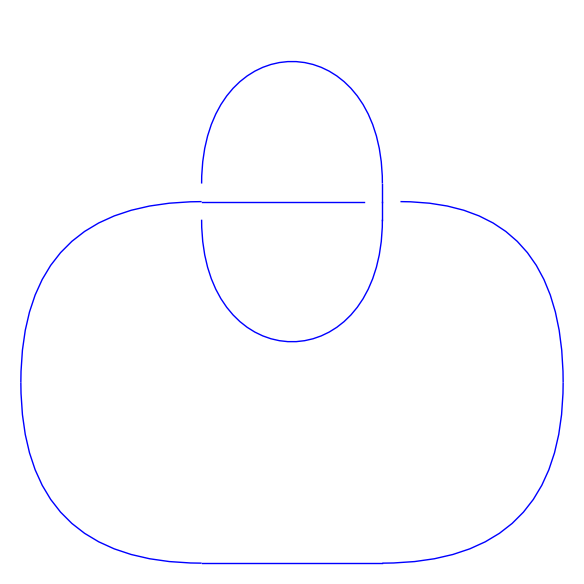

In [38]:
M = Link([[1,3, 2, 4], [4, 2, 3, 1]])
print(M.jones_polynomial(skein_normalization = True))
M.plot()

In [ ]:
M = Link([[3, 4, 1, 1], [2, 2, 4, 3]])
print(M.jones_polynomial(skein_normalization = True, algorithm = 'statesum'))
M.plot()

In [ ]:
L = Link([[3, 3, 4, 2], [4, 1, 1, 2]])
L.plot()

In [ ]:
L.jones_polynomial(skein_normalization = True)

In [ ]:
seq = [[0, 3, 2], [2, 5, 2], [4, 1, -2]]
orientList = isRealizable(seq, f_list = True)
print(orientList)
PD = planarDiagram(seq, orientList)
print(PD)
Link(PD[0]).plot()

In [ ]:
function([0, 1, 2, 3, 4, 5])

In [ ]:
A = [0, 1, 2, 3]
Ap = [iii if iii != 2 else 5 for iii in A]
Ap

In [ ]:
B = [[2, 4, 1, 5], [4, 2, 5, 1]]
Bp = [[node[iii] if node[iii] != 5 else 1 for iii in range(4)] for node in B]
Bp

In [ ]:
B

In [ ]:
del B[-1]

In [ ]:
C = [1]
del C[-1]
C += [2, 3]
C

In [ ]:
print(reorder([[4, 2, 5, 1], [5, 2, 6, 3], [6, 4, 1, 3]]))

In [ ]:
pd_list = [[3, 6, 4, 1], [4, 2, 5, 1], [5, 2, 6, 3]]

In [ ]:
labelReverse(pd_list, 5, 1)